In [1]:
from torchvision import datasets
import numpy as np
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from vit_pytorch import ViT  # ViT model


BATCH_SIZE  =32
mnist_transforms = transforms.Compose([transforms.ToTensor()])
train_val_dataset = datasets.MNIST(root="./datasets/", train=True, download=False, transform=mnist_transforms)
test_dataset = datasets.MNIST(root="./datasets/", train=False, download=False, transform=mnist_transforms)
train_size = int(0.9 * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset=train_val_dataset, lengths=[train_size, val_size])
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)


device = 'cuda' if torch.cuda.is_available() else 'cpu'


from torch import nn

class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature = nn.Sequential(
            #1
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2),   # 28*28->32*32-->28*28
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),  # 14*14
            
            #2
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),  # 10*10
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),  # 5*5
            
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=16*5*5, out_features=120),
            nn.Tanh(),
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=10),
        )
        
    def forward(self, x):
        return self.classifier(self.feature(x))
    

### Load trained models

model_vit_v1 = ViT(
    image_size=28,       # MNIST images are 28x28
    patch_size=4,        # 4 patches per dimension (28/7)
    num_classes=10,      # 10 output classes for digits 0-9
    dim=64,             # Embedding dimension
    depth=6,             # Number of transformer layers
    heads=8,             # Number of attention heads
    mlp_dim=128,         # Hidden dimension in MLP layers
    dropout=0.1,         # Dropout rate in transformer
    emb_dropout=0.1,     # Dropout rate for embeddings
    channels = 1
).to(device)


model_vit_v2 = ViT(
    image_size=28,       # MNIST images are 28x28
    patch_size=7,        # 4 patches per dimension (28/7)
    num_classes=10,      # 10 output classes for digits 0-9
    dim=64,             # Embedding dimension
    depth=6,             # Number of transformer layers
    heads=8,             # Number of attention heads
    mlp_dim=128,         # Hidden dimension in MLP layers
    dropout=0.1,         # Dropout rate in transformer
    emb_dropout=0.1,     # Dropout rate for embeddings
    channels = 1
).to(device)

model_lenet5 = LeNet5().to(device)

In [2]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
MODEL_NAME = "LENeT5_mnist.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME


model_lenet5.load_state_dict(torch.load(MODEL_SAVE_PATH))


MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
MODEL_NAME = "ViT_v2_mnist.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

model_vit_v2.load_state_dict(torch.load(MODEL_SAVE_PATH))


MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
MODEL_NAME = "ViT_v1_mnist.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

model_vit_v1.load_state_dict(torch.load(MODEL_SAVE_PATH))

/tmp/ipykernel_45419/2789388921.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_lenet5.load_state_dict(torch.load(MODEL_SAVE_PATH))
/tmp/ipykernel_45419/2789388921

<All keys matched successfully>

In [16]:
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import PyTorchClassifier
import torch.nn as nn
from torch.optim import Adam
from torchmetrics import Accuracy

In [112]:
model_id = model_vit_v1

loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model_id.parameters(), lr=0.001)
classifier = PyTorchClassifier(model=model_id,clip_values=(0,1),loss=loss_fn,optimizer=optimizer,input_shape=(1,28,28),nb_classes=10)
nb_correct=0
for x,y in test_dataloader:
    y_pred = classifier.predict(x)
    nb_correct+=np.sum(np.argmax(y_pred,axis=1)==y.detach().cpu().numpy())

print("Accuracy on benign test examples: {}%".format(nb_correct/len(test_dataset)*100))

Accuracy on benign test examples: 98.03%


In [90]:
np.linspace(0.01,0.1,5)

array([0.01  , 0.0325, 0.055 , 0.0775, 0.1   ])

In [113]:
epsilons = [0.0001,0.0003,0.0005,0.001,0.005,0.01,0.05,0.1]
epsilons_CNN = list(np.linspace(0.01,0.1,5))
accuracies = []
REPORTS= []
for eps in epsilons:
    nb_missclassified_FGSM=0
    nb_missclassified_PGD=0


    REPORT = {'original':{'y':[],'x':[]},'attack_FGSM':{'y':[],'x':[]},'attack_PGD':{'y':[],'x':[]}}


    attack = FastGradientMethod(estimator=classifier, eps=eps)
    nb_correct_attack=0
    torch.manual_seed(10)
    for x,y in test_dataloader:
        REPORT['original']['x'].append(x)

        x_test_fgm = attack.generate(x=x.detach().cpu().numpy())
        REPORT['attack_FGSM']['x'].append(x_test_fgm)

        #y_pred = classifier.predict(x)
        REPORT['original']['y'].append(y.detach().cpu().numpy())
        y_pred = classifier.predict(x_test_fgm)
        REPORT['attack_FGSM']['y'].append(np.argmax(y_pred,axis=1))

        nb_correct_attack+=np.sum(np.argmax(y_pred,axis=1)==y.detach().cpu().numpy())

    print("Accuracy on adversarial test examples with eps:{} : {}%".format(eps,nb_correct_attack/len(test_dataset) * 100))



    REPORT['original']['y'] = np.concatenate(REPORT['original']['y'])
    REPORT['original']['x'] = np.concatenate(REPORT['original']['x'])

    REPORT['attack_FGSM']['y'] = np.concatenate(REPORT['attack_FGSM']['y'])
    REPORT['attack_FGSM']['x'] = np.concatenate(REPORT['attack_FGSM']['x'])

    REPORTS.append(REPORT)

Accuracy on adversarial test examples with eps:0.0001 : 97.74000000000001%
Accuracy on adversarial test examples with eps:0.0003 : 95.48%
Accuracy on adversarial test examples with eps:0.0005 : 89.60000000000001%
Accuracy on adversarial test examples with eps:0.001 : 65.34%
Accuracy on adversarial test examples with eps:0.005 : 36.08%
Accuracy on adversarial test examples with eps:0.01 : 32.06%
Accuracy on adversarial test examples with eps:0.05 : 20.919999999999998%
Accuracy on adversarial test examples with eps:0.1 : 13.08%


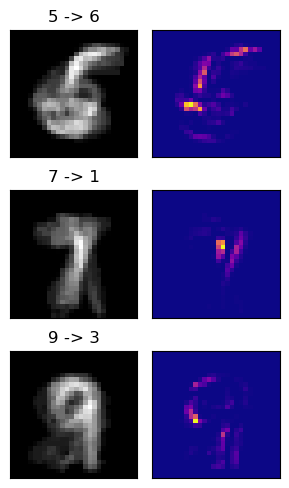

In [121]:
import matplotlib.pyplot as plt
c1_list = [5,7,9]
c2_list = [6,1,3]

x_false = []
x_true =[]

eps_summary = 0.0005

REPORT_plot = REPORTS[epsilons.index(eps_summary)]
### get index of c1 in original
#print(REPORT)
row = 0
fig,ax = plt.subplots(3,2,figsize=(3,5))
for c1,c2 in zip(c1_list,c2_list):
    #x_false = []
    #x_true =[]
    ind = REPORT_plot['original']['y'] == c1

    x_true = REPORT_plot['original']['x'][ind]
    ### get index in pertubed of c1 but with c2 predictions
    ind_wrong = REPORT_plot['attack_FGSM']['y'][ind] == c2
    ind_wrong
    x_false_FGSM = REPORT_plot['attack_FGSM']['x'][ind][ind_wrong]


    ax[row,0].imshow(x_false_FGSM.mean(axis=0)[0,:,:],cmap='gray')
    ax[row,0].set_title(f"{c1} -> {c2}")
    ax[row,1].imshow(np.abs(x_true.mean(axis=0)[0,:,:]-x_false_FGSM.mean(axis=0)[0,:,:])**4,cmap='plasma')
    #ax[row,2].imshow(np.abs(x_true.mean(axis=0)[0,:,:].numpy()-x_false_PGD.mean(axis=0)[0,:,:].numpy())**4,cmap='plasma')
    ax[row,0].set_xticks([])
    ax[row,1].set_xticks([])
    ax[row,0].set_yticks([])
    ax[row,1].set_yticks([])
    row+=1

fig.tight_layout()

In [122]:
fig.savefig('/home/sven/Downloads/Adv_example_VIT.pdf')